In [50]:
import numpy as np
from tqdm import tqdm
from scipy.stats import ortho_group
import math
import random
import matplotlib.pyplot as plt

In [51]:
#parameters
max_range = 100
min_range = 50
rows = 100
columns = 100
num_of_simulations = 1
iterations = 1000
dim = min(rows, columns)
b_noise_mean = 0
b_noise_sd = 1
x_noise_mean = 0
x_noise_sd = 10
data_repeat = 10

In [55]:
#creating the matrix based on the parameters we get
def creating_matrix(max_range, min_range, rows, columns, x_noise_mean, x_noise_sd, b_noise_mean, b_noise_sd):
    B = np.random.rand(rows, columns)
    u, s, vh = np.linalg.svd(B, full_matrices=True)
    s_new = np.zeros(s.shape)
    s_new[0] = max_range
    rank = min(rows, columns)
    s_new[rank-1] = min_range
    
    for i in range(min(rows, columns)):
        if i == 0 or i == rank-1:
            continue
        s_new[i] = (random.uniform(0, 1)) * (max_range-min_range) + min_range

    s_new.sort()
    s_temp = np.copy(s_new)
    for i in range(min(rows, columns)):
        s_new[i] = s_temp[rank - 1 - i]

    A = np.dot(u[:, :rank] * s_new, vh)
    x = np.zeros(columns)
    for i in range(columns):
        x[i] = np.random.normal(x_noise_mean, x_noise_sd)
    M = np.dot(A, x)
    b = M + np.random.normal(b_noise_mean, b_noise_sd)
    alpha = s_new[rank-1] * s_new[rank-1]
    beta = s_new[0] * s_new[0]
    b_norm = np.linalg.norm(b)
    penrose_inverse = np.linalg.pinv(A)
    R = np.linalg.norm(penrose_inverse) * np.linalg.norm(b)
    L = beta * R + s_new[0] * b_norm
    return b, A, alpha, beta, R, L


#calculating the function value
def loss(A, x, b):
    return 0.5*np.linalg.norm(np.dot(A, x)-b)**2


#calculating the gradient value
def gradient(A, x, b):
    return np.dot(np.transpose(A), (np.dot(A, x)-b))


#ploting the results
def plot(SGD, SGD5, SGD20, SGD40, SVRG, SVRG_pass,  iterations, sim):
    if SGD is not None:
        plt.plot(range(1, iterations+1), SGD / iterations * sim, 'green')
    if SGD5 is not None:
        plt.plot(range(1, iterations+1), SGD5 / iterations * sim, 'red')
    if SGD20 is not None:
        plt.plot(range(1, iterations+1), SGD20 / iterations * sim, 'blue')
    if SGD40 is not None:
        plt.plot(range(1, iterations+1), SGD40 / iterations * sim, 'grey')
    if SVRG is not None:
        plt.plot(SVRG_pass, SVRG / iterations * sim, 'black')

    plt.legend(['SGD', 'SGD5', 'SGD20'
                , 'SGD40', 'SVRG'], loc='best')
    plt.yscale('log')
    plt.xscale('log')
    plt.grid(True)
    plt.ylabel('F Value')
    plt.xlabel('SO calls')
    plt.title('Stochastic gradient descent methods comparison')
    plt.savefig('Stochastic gradient descent methods comparison.png')
    plt.show()
    
#batch Stochastic_gradient_descent
def Stochastic_gradient_descent(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, batch_size):
    scores_SGD = np.zeros(iterations)
    x_sum = 0
    x = np.zeros(rows)
    scores_SGD[0] += loss(matrix, x, matrix_with_noise)
    x_sum += x
    for i in range(1, iterations):
        for j in range(int(rows/batch_size)):
            rand_indexes = np.random.randint(0, rows - 1, batch_size)
            A_tilda = matrix[rand_indexes, :]
            b_tilda = matrix_with_noise[rand_indexes]
            step = 2/(alpha*(j+1))
            x = x - step * gradient(A_tilda,x,b_tilda)/batch_size
        x_sum += x
        x_avg = x_sum/i
        scores_SGD[i] += loss(matrix, x_avg, matrix_with_noise)
    return scores_SGD

#SVRG
def SVRG_function(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, data_repeat, batch_size):
    number_of_iterations = int((iterations / (data_repeat + 1)) + 1)
    x_sum = 0
    scores_SVRG = np.zeros(number_of_iterations)
    SVRG_pass = []
    x = np.zeros(rows)
    scores_SVRG[0] += loss(matrix, x, matrix_with_noise)
    SVRG_pass.append(1)
    x_sum += x
    for i in range(1,number_of_iterations):
        x_prev = x
        gradient_score = gradient(matrix, x_prev, matrix_with_noise) / rows
        for j in range(int(data_repeat * rows / batch_size)):
            step = 1 / beta
            #get random i's
            rand_indexes = np.random.randint(0, rows - 1, batch_size)
            A_tilda = matrix[rand_indexes, :]
            b_tilda = matrix_with_noise[rand_indexes]
            # w(t)=w(t-1)-step(GRD(W(T-1)-GRD(W=y)+Mu)
            x = x - step * (gradient(A_tilda, x, b_tilda) / batch_size - gradient(A_tilda, x_prev, b_tilda) / batch_size + gradient_score)
        x_sum += x
        SVRG_pass.append(i * repeat + i)
        x_avg = x_sum / i
        scores_SVRG[i] += loss(matrix, x_avg, matrix_with_noise)
    return scores_SVRG, SVRG_pass

In [56]:
# #Kfir's code
# def run_GD(T,x_1,A,b,R,L):
#     scores = np.zeros(T)
#     for t in range(1, T):
#         if t == 1:
#             x_t = x_1
#             score = f(A, x_t, b)
#             scores[0] += score
#         step = R / (L * np.sqrt(t))
#         x_t_plus_1 = x_t - step * gradient_f(A, x_t, b)
#         x_t = x_t_plus_1
#         score = f(A, x_t, b)
#         scores[t] += score
#     return scores


# #Kfir's code
# def f(A,x,b):
#     return 0.5*np.linalg.norm(A@x-b)**2


# #Kfir's code
# def gradient_f(A,x,b):
#     return np.transpose(A)@(A@x-b)

# #Kfir's code
# def get_set_params(sigma_max,sigma_min,b,A):
#     ##from lec2 slide 21
#     alpha = sigma_min**2
#     beta = sigma_max**2
#     R = np.linalg.norm(np.linalg.pinv(A)) * np.linalg.norm(b)
#     ##from lec1 slide 11
#     L = sigma_max**2 * R + sigma_max*np.linalg.norm(b)
#     return alpha,beta,R,L

# #Kfir's code
# def run_GD_smooth(T,x_1,A,b,beta):
#     scores = np.zeros(T)
#     for t in range(1, T):
#         if t == 1:
#             x_t = x_1
#             score = loss(A, x_t, b)
#             scores[0] += score
#         step = 1 / beta
#         x_t_plus_1 = x_t - step * gradient(A, x_t, b)
#         x_t = x_t_plus_1
#         score = loss(A, x_t, b)
#         scores[t] += score
#     return scores

#Kfir's code
# def show_plot(scores_GD, scores_smooth_GD, scores_accelerate_GD,scores_SGD,is_PD):
#     #print (scores_accelerate_GD/T * num_of_simulations)
#     if scores_SGD != None:
#         print (scores_SGD/T * num_of_simulations)
#         plt.plot(range(1, T + 1), scores_SGD / T * num_of_simulations, 'black')
#     plt.plot(range(1,T+1), scores_GD/T*num_of_simulations,'red')
#     plt.plot(range(1,T+1), scores_smooth_GD/T*num_of_simulations,'green')
#     plt.plot(range(1,T+1), scores_accelerate_GD/T*num_of_simulations,'blue')
#     plt.legend(['GD','Smooth GD','Accelerate GD','SGD'], loc='best')
#     plt.yscale('log')
#     plt.xscale('log')
#     plt.grid(True)
#     plt.ylabel('f(x)')
#     plt.xlabel('#Iterations')
#     if is_PD:
#         plt.title('GD Methods for Positive Definite Matrix over Least-Squares function')
#         plt.savefig('PD_matrix_opt_methods.png')
#     else:
#         plt.title('GD Methods for Positive Semi-Definite Matrix over Least-Squares function')
#         plt.savefig('PSD_matrix_opt_methods.png')
#     plt.show()
#     plt.clf()


# #Kfir's code
# def run_GD_accelerate_smooth(T,x_1,A,b,beta):
#     scores = np.zeros(T)
#     for t in range(1, T):
#         if t == 1:
#             x_t, y_t = x_1, x_1
#             score = loss(A, x_t, b)
#             scores[0] += score
#         step = 1 / beta
#         factor = (1 - get_lambda_value(t)) / get_lambda_value(t + 1)
#         y_t_plus_1 = x_t - step * gradient(A, x_t, b)
#         x_t_plus_1 = (1 - factor) * y_t_plus_1 + factor * y_t
#         x_t = x_t_plus_1
#         y_t = y_t_plus_1
#         score = loss(A, x_t, b)
#         scores[t] += score
# #     return scores

# #Kfir's code
# ###Nesterov’s accelerated gradient descent for smooth and strongly convex###
# def run_GD_accelerate_strong_convex(T,x_1,A,b,beta,factor):
#     scores = np.zeros(T)
#     for t in range(1, T):
#         if t == 1:
#             x_t, y_t = x_1, x_1
#             score = loss(A, x_t, b)
#             scores[0] += score
#         step = 1 / beta
#         y_t_plus_1 = x_t - step * gradient(A, x_t, b)
#         x_t_plus_1 = (1 + factor) * y_t_plus_1 - factor * y_t
#         x_t = x_t_plus_1
#         y_t = y_t_plus_1
#         score = loss(A, x_t, b)
#         scores[t] += score
#     return scores

# #Kfir's code
# def get_gradient_scores(min_range,max_range, PD, rows, columns, x_noise_mean, x_noise_sd, b_noise_mean, b_noise_sd, iterations):
#     scores_GD = np.zeros(T)
#     scores_smooth_GD = np.zeros(T)
#     scores_accelerate_GD = np.zeros(T)
#     for i in tqdm(range(num_of_simulations),total=num_of_simulations):
#         singular_values = [random.uniform(sigma_min, sigma_max) for i in range(dim)]
#         singular_values.sort(reverse = True)
#         singular_values[-1], singular_values[0] = sigma_min, sigma_max  # fixed sigma_min and sigma_max
#         matrix_with_noise, matrix, alpha, beta, R, L = creating_matrix(max_range, min_range, rows, columns,
#                                                                    PD, x_noise_mean, x_noise_sd, b_noise_mean, b_noise_sd)

# #         x_1 = np.zeros(dim)
# #         scores_SGD = run_SGD(T,x_1,A,b,alpha)
# #         scores_GD = run_GD(T, x_1, A, b,R,L)
#         scores_GD = gradient_descent(T, matrix, matrix_with_noise,R,L)
# #         scores_smooth_GD = run_GD_smooth(T, x_1, matrix, matrix_with_noise, beta)
#         scores_smooth_GD = gradient_descent_for_smooth(iterations, matrix, matrix_with_noise, beta)
        
# #         if PD:
# #             k = beta/alpha
# #             factor = (np.sqrt(k)-1)/(np.sqrt(k)+1)
# #             scores_accelerate_GD = run_GD_accelerate_strong_convex(T, x_1, matrix, matrix_with_noise, beta, factor)
# #         else:
# #             scores_accelerate_GD = run_GD_accelerate_smooth(T, x_1, matrix, matrix_with_noise, beta)
            
#         scores_accelerate_GD =accelerated_gradient_descent(iterations, matrix, matrix_with_noise, beta, alpha, PD)
#     return scores_GD,scores_smooth_GD,scores_accelerate_GD,scores_SGD


# #Kfir's code
# def get_matrix_fix_singular_values(singular_values):
#     U = ortho_group.rvs(dim=dim)
#     V = ortho_group.rvs(dim=dim)
#     S = np.diag(singular_values)
#     A = U @ S @ V
#     return A

# #Kfir's code
# dim = 100
# T = 1000
# num_of_simulations = 10
# lambda_t_dict = {}

# def accelerated_gradient_descent(iterations, matrix, matrix_with_noise, beta, alpha, PD):
#     scores_accelerate_GD = np.zeros(iterations)
#     if PD == False:
#         lambda_values = get_lambda(iterations+1)
#     else:
#         factor = (np.sqrt(beta / alpha) - 1) / (np.sqrt(beta / alpha) + 1)
#     for t in range(1, iterations):
#         if t == 1:
#             x, y = np.zeros(dim), np.zeros(dim)
#             scores_accelerate_GD[0] += loss(matrix, x, matrix_with_noise)
#         if PD == False:
#             factor = (1 - lambda_values[t]) / lambda_values[t + 1]
#         y_next = x - (1 / beta) * gradient(matrix, x, matrix_with_noise)
#         if PD:
#             x_next = (1 + factor) * y_next - factor * y
#         else:
#             x_next = (1 - factor) * y_next + factor * y
#         x = x_next
#         y = y_next
#         scores_accelerate_GD[t] += loss(matrix, x, matrix_with_noise)
#     return scores_accelerate_GD

# # this is instead of run_GD
# def gradient_descent(iterations, matrix, matrix_with_noise, R, L):
#     loss_GD = np.zeros(iterations)
#     for t in range(1, iterations):
#         if t == 1:
#             x = np.zeros(dim)
#             loss_GD[0] += loss(matrix, x, matrix_with_noise)
#         step_loss = (R / (L * np.sqrt(t))) * gradient(matrix, x, matrix_with_noise)
#         x = x - step_loss
#         loss_GD[t] += loss(matrix, x, matrix_with_noise)
#     return loss_GD

# def gradient_descent_for_smooth(iterations, matrix, matrix_with_noise, beta):
#     scores_smooth_GD = np.zeros(iterations)
#     for t in range(1, iterations):
#         if t == 1:
#             x = np.zeros(dim)
#             scores_smooth_GD[0] += loss(matrix, x, matrix_with_noise)
#         step_loss = gradient(matrix, x, matrix_with_noise) / beta
#         x = x - step_loss
#         scores_smooth_GD[t] += loss(matrix, x, matrix_with_noise)
#     return scores_smooth_GD






# def get_lambda(number_of_iterations):
#     lambda_array = np.zeros(number_of_iterations)
#     for k in range(number_of_iterations):
#         if k == 0:
#             continue
#         temp = (lambda_array[k-1]*lambda_array[k-1])
#         temp = 1+4*temp
#         temp = np.sqrt(temp)
#         temp = temp + 1
#         temp = temp /2 
#         lambda_array[k] = temp
#     return lambda_array

# #Kfir's code
# def get_avg_x(weights,t):
#     sum_x = 0
#     for s in range(t):
#         sum_x += (2*s/t*(t-1))*weights[s]
#     return sum_x/t

# #Kfir's code
# def gradient_f_i(a,x,b):
#     return ((np.dot(np.transpose(a),x))-b)*a

# #Kfir's code
# def get_random_index(A):
#     prob_vec = []
#     for row in A:
#         p = np.linalg.norm(row)**2/np.linalg.norm(A, 'fro')**2
#         prob_vec.append(p)
#     idx = np.random.choice(np.arange(0, A.shape[0]), p=prob_vec)
#     return idx

# #Kfir's code
# def estimate_gradient_f(A, x, b,sampled_idx):
#     sampled_idx = random.randint(0,len(x)-1)
#     # sampled_idx = t
#     # grad = (np.transpose(A[sampled_idx]) @ (A[sampled_idx] @ x[sampled_idx] - b[sampled_idx]))
#     grad = (np.transpose(A[sampled_idx])*x[sampled_idx]-b[sampled_idx])@A[sampled_idx]
#     return grad

# #Kfir's code
# def run_SGD(T,x_1,A,b,alpha,N):
#     scores = np.zeros(T)
#     #weights = [[]]*T
#     sum = 0
#     m = len(x_1) # number of rows
#     for t in range(1, T):
#         if t == 1:
#             x_t = x_1 # x_1 is zeros in the start
#             score = f(A, x_t, b)
#             scores[0] += score
#             weights[0] = x_t
#         step = 2/(alpha*(t+1))

#         for j in range(int(m/N)): # N is the number of samples in every batch
#             rand_indexes = random.sample(range(0, len(x_t)), N) # len(x_t)= rows, need to fix, need to take batch from all sampels
#             A_tilda = A[rand_indexes, :]
#             b_tilda = b[rand_indexes]
#             grad = np.zeros(len(x_t)) #len(x_t)= columns
#             for i in range(N):
#                 grad += batch_gradient(A_tilda[i],x_t,b_tilda[i])/N
#             x_t_plus_1 = x_t - step * grad
#             x_t = x_t_plus_1
#         weights[t] = x_t
#         avg_x = sum(weights[:t])/t
#         score = f(A, avg_x, b)
#         scores[t] += score
#     return scores


# def run_SVRG(epochs,k,N,x_1,A,b,beta):
#     passes_SVRG = []
#     scores = np.zeros(epochs)
#     sum_x_t = 0

#     for s in range(1,epochs):
#         if s == 1:
#             x_t = x_1
#             score = f(A, x_t, b)
#             passes_SVRG.append(1)
#             scores[0] += score
#             sum_x_t += x_t
#         y_s = x_t
#         gradient = gradient_f(A,y_s, b)/dim
#         max_iter = int(k * dim / N)
#         for t in range(max_iter):
#             rand_idx = np.random.randint(0, dim - 1, N)
#             b_tilda = b[rand_idx]
#             A_tilda = A[rand_idx, :]
#             step = 1 / beta
#             x_t = x_t - step * (gradient_f(A_tilda,x_t, b_tilda)/N - gradient_f(A_tilda,y_s, b_tilda)/N + gradient)
#         sum_x_t += x_t
#         passes_SVRG.append(s * k + s)
#         avg_x = sum_x_t/s
#         score = f(A, avg_x, b)
#         scores[s] += score
#     return scores,passes_SVRG

# #batch gradient
# def batch_gradient(A_til, x, B_till):
#     temp = np.transpose(A_til)
#     temp = np.dot(temp,x)
#     temp = temp - B_till
#     temp = temp * A_til
#     return (temp)

100%|██████████| 1/1 [00:04<00:00,  4.59s/it]


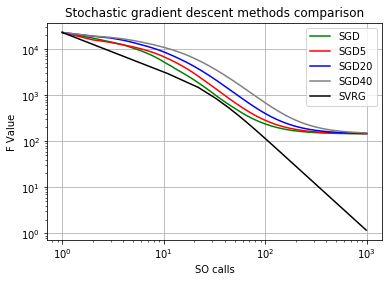

In [57]:
for i in tqdm(range(num_of_simulations),total=num_of_simulations):
    SGD = SGD5 = SGD20 = SGD40 = SVRG = None
    matrix_with_noise, matrix, alpha, beta, R, L = creating_matrix(max_range, min_range, rows, columns,
                                                               x_noise_mean, x_noise_sd, b_noise_mean, b_noise_sd)
    SGD = Stochastic_gradient_descent(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, batch_size=1)
    SGD5 = Stochastic_gradient_descent(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, batch_size=5)
    SGD20 = Stochastic_gradient_descent(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, batch_size=20)
    SGD40 = Stochastic_gradient_descent(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, batch_size=40)
    SVRG, SVRG_pass = SVRG_function(iterations, rows, columns, matrix, matrix_with_noise, alpha, dim, data_repeat, batch_size=5)

plot(SGD, SGD5, SGD20, SGD40, SVRG, SVRG_pass,  iterations, num_of_simulations)